✅ CIST 기반 Accuracy: 0.9392
✅ CIST 기반 ROC-AUC: 0.9813

[Classification Report]
              precision    recall  f1-score   support

          CN       0.92      0.96      0.94       371
          DM       0.96      0.92      0.94       419

    accuracy                           0.94       790
   macro avg       0.94      0.94      0.94       790
weighted avg       0.94      0.94      0.94       790


🏆 [Top 10 High Risk Patients]
             PTID  DM_Probability         Interest_Category
1801   301_S_6592        0.999915  High Risk DM (Confirmed)
1952   027_S_6733        0.999908  High Risk DM (Confirmed)
2592  941_S_10015        0.999868  High Risk DM (Confirmed)
3877  010_S_10870        0.999848  High Risk DM (Confirmed)
3589  131_S_10801        0.999847  High Risk DM (Confirmed)
2121   003_S_6833        0.999834  High Risk DM (Confirmed)
2111   305_S_6810        0.999803  High Risk DM (Confirmed)
2730  941_S_10135        0.999793  High Risk DM (Confirmed)
662    007_S_1248       

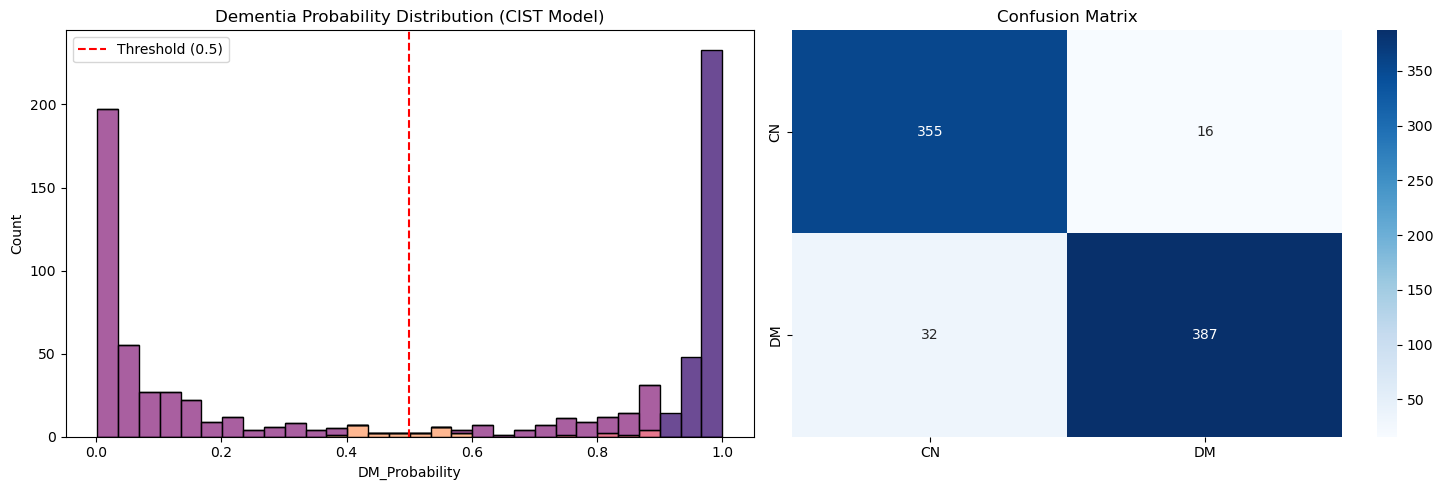

['ADNI_CIST_Predictor_Final.joblib']

In [1]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.experimental import enable_iterative_imputer  # noqa: F401
from sklearn.impute import IterativeImputer
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier, VotingClassifier
from sklearn.metrics import (
    classification_report, accuracy_score, roc_auc_score,
    confusion_matrix, f1_score, roc_curve
)

# 1. 데이터 로드
# CIST 컬럼과 기본 정보가 포함된 데이터셋을 불러옵니다.
df = pd.read_csv("ADNI_Full_Baseline_With_CIST.csv")

# 2. 타깃 정의: CN(0) vs DM(1 = MCI+AD)
# label: 0=CN, 1=MCI, 2=AD 가정
df["target"] = (df["label"] != 0).astype(int)

# 3. 피처 선택 (바이오마커 제외, 인지는 CIST 세부 항목만 사용)
cognitive_cols = [
    "CIST_ORIENT", "CIST_ATTENTION", "CIST_EXEC", 
    "CIST_MEMORY", "CIST_LANGUAGE"
]
demo_health_cols = ["entry_age", "PTEDUCAT", "VSBPSYS", "BMI"]

# 성별 인코딩 (문자열 대응)
df["PTGENDER_num"] = df["PTGENDER"].map({"Male": 1, "Female": 2, 1: 1, 2: 2})

all_features = cognitive_cols + demo_health_cols + ["PTGENDER_num"]

# 4. 학습/검증 데이터 분할
X = df[all_features]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# 5. 전처리: MICE 임퓨터 + Clipping + Scaling
imputer = IterativeImputer(max_iter=10, random_state=42)
X_train_imp = pd.DataFrame(imputer.fit_transform(X_train), columns=all_features)
X_test_imp  = pd.DataFrame(imputer.transform(X_test), columns=all_features)

# 데이터 범위 제한 (Clipping) - 이상치 제어 및 CIST 점수 체계 준수
bounds = {
    "CIST_ORIENT": (0, 5), "CIST_ATTENTION": (0, 3),
    "CIST_EXEC": (0, 6), "CIST_MEMORY": (0, 10), "CIST_LANGUAGE": (0, 4),
    "PTEDUCAT": (0, 25), "BMI": (10, 60), "VSBPSYS": (70, 250), "entry_age": (40, 100)
}

for col, (low, high) in bounds.items():
    if col in X_train_imp.columns:
        X_train_imp[col] = X_train_imp[col].clip(low, high)
        X_test_imp[col]  = X_test_imp[col].clip(low, high)

scaler = StandardScaler()
X_train_sc = scaler.fit_transform(X_train_imp)
X_test_sc  = scaler.transform(X_test_imp)

# 6. 앙상블 모델 구축 (RF + HGB)
rf = RandomForestClassifier(
    n_estimators=500, class_weight="balanced", max_depth=10, random_state=42
)
hgb = HistGradientBoostingClassifier(
    max_iter=300, learning_rate=0.03, class_weight="balanced", random_state=42
)

model = VotingClassifier(
    estimators=[("rf", rf), ("hgb", hgb)],
    voting="soft"
)
model.fit(X_train_sc, y_train)

# 7. 예측 및 성능 평가
y_pred  = model.predict(X_test_sc)
y_proba = model.predict_proba(X_test_sc)[:, 1]

print(f"✅ CIST 기반 Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"✅ CIST 기반 ROC-AUC: {roc_auc_score(y_test, y_proba):.4f}")
print("\n[Classification Report]")
print(classification_report(y_test, y_pred, target_names=["CN", "DM"]))

# 8. 관심 환자 랭킹 생성 (치매 확률 기반)
test_results = df.loc[X_test.index, ["PTID", "label", "target"]].copy()
test_results["DM_Probability"] = y_proba
test_results["Predicted_Label"] = y_pred

def assign_interest(row):
    prob = row["DM_Probability"]
    actual = row["target"]
    if actual == 0 and prob >= 0.7:
        return "High Risk CN (Potential Converter)"
    elif actual == 1 and prob >= 0.9:
        return "High Risk DM (Confirmed)"
    elif 0.4 <= prob <= 0.6:
        return "Ambiguous (Monitor)"
    else:
        return "Standard"

test_results["Interest_Category"] = test_results.apply(assign_interest, axis=1)

# 위험도 순 정렬 및 저장
patient_ranking = test_results.sort_values(by="DM_Probability", ascending=False)
patient_ranking.to_csv("ADNI_CIST_Patient_Interest_Ranking.csv", index=False)

print("\n🏆 [Top 10 High Risk Patients]")
print(patient_ranking.head(10)[["PTID", "DM_Probability", "Interest_Category"]])
print(f"\n✅ 랭킹 결과가 'ADNI_CIST_Patient_Interest_Ranking.csv'로 저장되었습니다.")

# 9. 시각화 (확률 분포 및 지표)
plt.figure(figsize=(15, 5))

# (1) 확률 분포 히스토그램
plt.subplot(1, 2, 1)
sns.histplot(data=patient_ranking, x='DM_Probability', hue='Interest_Category', 
             multiple='stack', bins=30, palette='magma')
plt.axvline(0.5, color='red', linestyle='--', label='Threshold (0.5)')
plt.title('Dementia Probability Distribution (CIST Model)')
plt.legend()

# (2) Confusion Matrix
plt.subplot(1, 2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues",
            xticklabels=["CN", "DM"], yticklabels=["CN", "DM"])
plt.title("Confusion Matrix")

plt.tight_layout()
plt.savefig("CIST_Model_Analysis.png")
plt.show()

# 10. 모델 패키지 저장
model_package = {
    "model": model,
    "imputer": imputer,
    "scaler": scaler,
    "features": all_features,
    "bounds": bounds,
}
joblib.dump(model_package, "ADNI_CIST_Predictor_Final.joblib")